### Exploration of the most funny and the less funny caption

#### Data importation


In [1]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys


root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)

from src.utils.paths import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)


Root folder at:  /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [2]:
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

display(dataA[0])



,caption,mean,precision,votes,not_funny,somewhat_funny,funny
rank,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6
...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0


In [3]:
def add_funny_ratios(df):
    """
    Adds ratio columns based on 'Funny' and 'Not funny' columns.
    """
   
    
    df['funny_over_unfunny'] = n.where(df['not_funny'] != 0, df['funny'] / df['not_funny'], n.nan)
    df['funny_over_total'] = n.where(df['votes'] != 0, df['funny'] / df['votes'], n.nan)
    df['unfunny_over_total'] = n.where(df['votes'] != 0, df['not_funny'] / df['votes'], n.nan)
    
    return df

# Apply the function to every DataFrame in your list
dataA = [add_funny_ratios(df) for df in dataA]

#### Show number of votes per caption

In [64]:
# Basic stat new column
col = 'funny_over_total'

stats = []
for i, df in enumerate(dataA):
    if col in df.columns:
        stats.append({
            'df_index': i,
            'count': df[col].count(),
            'na_count': df[col].isna().sum(),
            'mean': df[col].mean(),
            'min': df[col].min(),
            'max': df[col].max()
        })

stats_df = pd.DataFrame(stats)
print(stats_df)
print(stats_df.describe())

     df_index  count  na_count      mean  min       max
0           0   3905         0  0.011334  0.0  0.263158
1           1   3325         0  0.013936  0.0  0.279070
2           2   4399         0  0.017593  0.0  0.593750
3           3   4141         0  0.028617  0.0  0.454545
4           4   3951         0  0.053903  0.0  0.285714
..        ...    ...       ...       ...  ...       ...
379       379   5159         0  0.026185  0.0  0.236533
380       380   5188         0  0.033187  0.0  0.254098
381       381   5513         0  0.035815  0.0  0.276288
382       382   6157         0  0.028785  0.0  0.212642
383       383   4958         0  0.030222  0.0  0.197721

[384 rows x 6 columns]
         df_index         count  na_count        mean         min         max
count  384.000000    384.000000     384.0  384.000000  384.000000  384.000000
mean   191.500000   5970.515625       0.0    0.034949    0.000085    0.309992
std    110.995495   1776.089463       0.0    0.009778    0.001540    0

#### Find most funny and most unfunny

In [11]:

def find_best_and_worth(dataA, var1, var2):
    """ var 1 is funny and var 2 should be unfunny """
    max_funny_value = float('-inf')
    max_funny_row = None
    max_funny_df_index = None
    max_funny_idx_in_df = None

    max_not_funny_value = float('-inf')
    max_not_funny_row = None
    max_not_funny_df_index = None
    max_not_funny_idx_in_df = None
    
    # Boucle sur tous les DataFrames
    for i, df in enumerate(dataA):
        if var1 in df.columns and var2 in df.columns:

            # Max de Funny
            if not df[var1].empty:
                idx_max_funny = df[var1].idxmax()
                if df.loc[idx_max_funny, var1] > max_funny_value:
                    max_funny_value = df.loc[idx_max_funny, var1]
                    max_funny_row = df.loc[idx_max_funny]
                    max_funny_df_index = i
                    max_funny_idx_in_df = idx_max_funny

            # Max de Not funny
            if not df[var2].empty:
                idx_max_not_funny = df[var2].idxmax()
                if df.loc[idx_max_not_funny, var2] > max_not_funny_value:
                    max_not_funny_value = df.loc[idx_max_not_funny, var2]
                    max_not_funny_row = df.loc[idx_max_not_funny]
                    max_not_funny_df_index = i
                    max_not_funny_idx_in_df = idx_max_not_funny

    print("---- Résultat ----")
    print(f"Max {var1} : valeur {max_funny_value} trouvée dans df[{max_funny_df_index+dataA_startID}] - Index is df {max_funny_df_index} and ligne index {max_funny_idx_in_df}")
    print(max_funny_row)
    print("\n")
    print(f"Max {var2}: valeur {max_not_funny_value} trouvée dans df[{max_not_funny_df_index+dataA_startID}]- Index is df {max_not_funny_df_index} and ligne index {max_not_funny_idx_in_df}")
    print(max_not_funny_row)    



In [13]:
find_best_and_worth(dataA,'funny_over_total','unfunny_over_total')

---- Résultat ----
Max funny_over_total : valeur 0.9989177489177489 trouvée dans df[598] - Index is df 88 and ligne index 0
caption               Mission accomplished. We will report that this...
mean                                                           2.998918
precision                                                      0.001083
votes                                                               924
not_funny                                                             0
somewhat_funny                                                        1
funny                                                               923
funny_over_unfunny                                                  NaN
funny_over_total                                               0.998918
unfunny_over_total                                                  0.0
Name: 0, dtype: object


Max unfunny_over_total: valeur 1.0 trouvée dans df[510]- Index is df 0 and ligne index 1987
caption               That's right, jus

#### Explore ratio funny-unfunny caption per images

The following plot shows that for all caption, there is only a few caption that are considered funny while a big number are considered not funny, this is shown by the ratio btw funny (mean >2) and unfunny (mean <1.5) captions for a same image.

In [ ]:
ratios = []  # Pour stocker le ratio de chaque DataFrame

for i,df in enumerate(dataA):
    # Vérifie que les colonnes existent
    
    nb_droles = (df['mean'] > 2).sum()
    nb_pas_droles = (df['mean'] < 1.5).sum()

        
    ratio = nb_droles / nb_pas_droles if nb_pas_droles != 0 else n.nan # Eviter division par zéro
    #ratios.append(ratio)
    ratios.append((i, ratio)) 


In [ ]:
import seaborn as sns 
#ratio_values = [r for i, r in ratios if not n.isnan(r)]

sns.boxplot(dataA["unfunny_over_total"])

TypeError: list indices must be integers or slices, not str

In [53]:

best_df_index, best_ratio = max(ratios, key=lambda x: x[1])
print("\n📊 Le DataFrame avec le plus grand ratio est :")
print(f"➡️ df[{best_df_index}] avec un ratio drôle/pas drôle de {best_ratio}")


📊 Le DataFrame avec le plus grand ratio est :
➡️ df[88] avec un ratio drôle/pas drôle de 0.00641025641025641


In [54]:
88+510

598

#### Comparaison internet 


In [39]:
import matplotlib.pyplot as plt

def get_score_plot(contest, N=100):
    df = dataA[contest]
    scores = df['mean']
    fig, ax = plt.subplots()
    ax.errorbar(df.index, df['mean'], yerr=df['precision'], fmt='_')
    ax.set_xlim(0, N)
    ax.set_ylim(scores[N], scores[0] + 0.05)
    ax.set_title(f'Cartoon caption contest {contest}')
    ax.set_ylabel('Average score')
    ax.set_xlabel('Rank')
    return fig

In [54]:
dataA[41].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_over_unfunny,funny_over_total,unfunny_over_total
rank,,,,,,,,,,
0,I'd like to see other people.,1.786585,0.046213,328,157,84,87,0.554140,0.265244,0.478659
1,"I know that look, you're not going to let this...",1.760000,0.047539,300,146,80,74,0.506849,0.246667,0.486667
2,I'd like to see other people.,1.739286,0.047997,280,136,81,63,0.463235,0.225000,0.485714
3,What a delightful coincidence. I'm also recent...,1.718147,0.048998,259,127,78,54,0.425197,0.208494,0.490347
4,Maybe his second week will go better.,1.714844,0.051655,256,134,61,61,0.455224,0.238281,0.523438


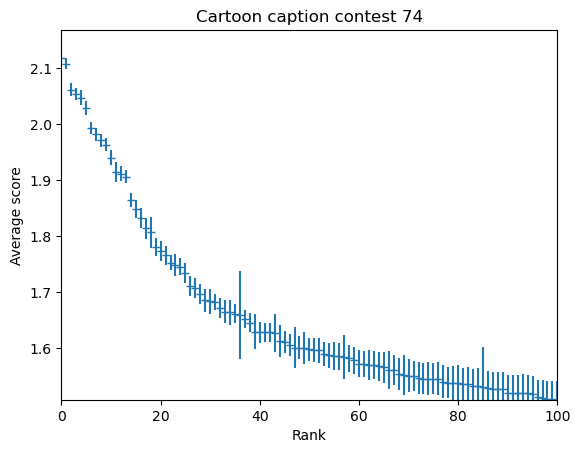

In [62]:
fig = get_score_plot(74)

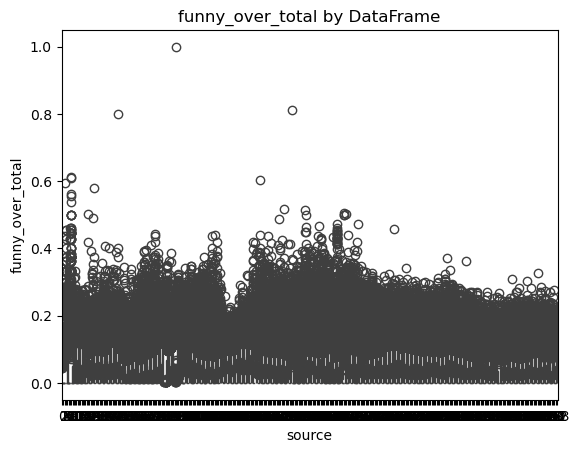

In [ ]:
combined = pd.concat(
    [
        df[['funny_over_total']].assign(source=i)
        for i, df in enumerate(dataA)
        if 'funny_over_total' in df.columns
    ],
    ignore_index=True
)

sns.boxplot(data=combined, x='source', y='funny_over_total')
plt.title("funny_over_total by DataFrame")
#plt.xlabel("DataFrame index")
plt.ylabel("funny_over_total")
plt.show()